In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode()
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


import sys
import os

# Go one directory up — from notebooks/ to the project root
sys.path.append(os.path.abspath(".."))

from src.modeling_utils import * 


plt.rc('figure',figsize=(18,9))
# %pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

output: instaed of creating a prediction whether a customer will churn or not it'll be more helpful to generate the probality of a customer will churn or no


Objective:

1. Identify the factors associated with customer churn.
2. Construct a model capable of accurately predicting the probability of a customer to churn.
3. Offer action plans for the bank to reduce credit card customer churn.

In [2]:
data = pd.read_csv('../data/BankChurners.csv')
data.drop(columns=["CLIENTNUM",'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)
data.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

| Variable      | Description |
| ----------- | ----------- |
| CLIENTNUM      | Client number. Unique identifier for the customer holding the account. Categorical nominal       |
| Attrition_Flag   | Internal event (customer activity) variable - if the account is closed then 1 else 0. Categorical binary. -> Churn Flag        |
| Customer_Age      | Demographic variable - Customer's Age in Years. Numerical discrete       |
| Total_Products_Purchased      | The total quantity of products purchased by the customer across all transactions.       |
| Total_Spend      | The total amount of money the customer has spent across all transactions.       |
| Average_Transaction_Value      | The average value of the customer's transactions, calculated as total spend divided by the number of transactions.       |
| Unique_Products_Purchased      | The number of different products the customer has purchased.       |
| Average_Days_Between_Purchases      | The average number of days between consecutive purchases made by the customer.       |
| Day_Of_Week      | The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).       |
| Hour      | The hour of the day when the customer prefers to shop, represented in a 24-hour format.       |
| Is_UK      | A binary variable indicating whether the customer is based in the UK (1) or not (0).       |
| Cancellation_Frequency      | The total number of transactions that the customer has cancelled.       |
| Cancellation_Rate      | The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.       |
| Monthly_Spending_Mean      | The average monthly spending of the customer.       |
| Monthly_Spending_Std      | The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.    |
| Spending_Trend      | A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.       |

## Column Detail:
1. **CLIENTNUM**: Client number. Unique identifier for the customer holding the account. Categorical nominal.
2. **Attrition_Flag**: Internal event (customer activity) variable - if the account is closed then 1 else 0. Categorical binary. -> Churn Flag
3. **Customer_Age**: Demographic variable - Customer's Age in Years. Numerical discrete.
4. **Gender**: Demographic variable - M=Male, F=Female. Categorical nominal.
5. **Dependent_count**: Demographic variable - Number of dependents. Numerical discrete.
6. **Education_Level**: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.). Categorical ordinal.
7. **Marital_Status**: Demographic variable - Married, Single, Divorced, Unknown. Categorical nominal.
8. **Income_Category**: Demographic variable - Annual Income Category of the account holder (< 
40K - 60K, 
80K, 
120K, >.). Categorical ordinal.
9. **Card_Category**: Product Variable - Type of Card (Blue, Silver, Gold, Platinum). Categorical ordinal.
10. **Months_on_book**: Period of relationship with bank. Numerical discrete.
11. **Total_Relationship_Count**: Total no. of products held by the customer. Numerical discrete.
12. **Months_Inactive_12_mon**: No. of months inactive in the last 12 months. Numerical discrete.
13. **Contacts_Count_12_mon**: No. of Contacts in the last 12 months. Numerical discrete.
14. **Credit_Limit**: Credit Limit on the Credit Card. Numerical continuous.
15. **Total_Revolving_Bal**: Total Revolving Balance on the Credit Card. Numerical discrete.
16. **Avg_Open_To_Buy**: Open to Buy Credit Line (Average of last 12 months). Numerical continuous.
17. **Total_Amt_Chng_Q4_Q1**: Change in Transaction Amount (Q4 over Q1). Numerical continuous.
18. **Total_Trans_Amt**: Total Transaction Amount (Last 12 months). Numerical discrete.
19. **Total_Trans_Ct**: Total Transaction Count (Last 12 months). Numerical discrete.
20. **Total_Ct_Chng_Q4_Q1**: Change in Transaction Count (Q4 over Q1). Numerical continuous.
21. **Avg_Utilization_Ratio**: Average Card Utilization Ratio. Numerical continuous.

In [3]:
data.describe()

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  1.012700e+04  10127.000000     10127.000000    10127.000000   
mean   7.391776e+08     46.325960         2.346203       35.928409   
std    3.690378e+07      8.016814         1.298908        7.986416   
min    7.080821e+08     26.000000         0.000000       13.000000   
25%    7.130368e+08     41.000000         1.000000       31.000000   
50%    7.179264e+08     46.000000         2.000000       36.000000   
75%    7.731435e+08     52.000000         3.000000       40.000000   
max    8.283431e+08     73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count         10127.000000           10127.000000  
mean              0.712222               0.274894  
std               0.238086               0.275691  
min               0.000000               0.000000  
25%               0.582000               0.023000  
50%               0.702000               0.176000  
75%               0.818000               0.503000  
max               3.714000               0.999000

In [3]:
data['Gender'] = data['Gender'].map({"M" : 1, "F":0})
data['Attrition_Flag'] = data['Attrition_Flag'].map({"Attrited Customer" : 1, "Existing Customer" : 0})
data.rename(columns={"Attrition_Flag" : "Churn_Flag"}, inplace=True)

# Split train and test data
- To avoid data leakage we will perform the train and test data prior to the Explatory data analysis and also to get the realistic represenation and later evalutate the model with unseen data 

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Churn_Flag'], axis=1)
y = data['Churn_Flag']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)


# Exploratory Data Analysis

Exploratory Data Analysis is an approach to analyze a dataset to understand their characteristics, summarize them, and identify patterns, anomalies and relationship. 

on this part we will get a better understanding on how the the feature are distributed, the relationship between each features, correlation, trends, and insight from the data, also in regards with the target variable. 

We will perform 3 types of data analysis:
1. Univariate Analysis
2. Bivariate Analysis 
3. Multivariate Analysis


In [5]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

Customer_Age  Gender  Dependent_count Education_Level Marital_Status  \
9524            52       1                3        Graduate        Married   
1586            37       0                3        Graduate         Single   
8615            45       0                3     High School        Married   
4667            43       0                3        Graduate         Single   
4887            44       0                5        Graduate         Single   

     Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
9524     $60K - $80K          Blue              44                         1   
1586  Less than $40K          Blue              36                         3   
8615  Less than $40K          Blue              32                         2   
4667  Less than $40K          Blue              30                         3   
4887  Less than $40K          Blue              37                         1   

      Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
9524                       2                      1       23889.0   
1586                       2                      3        6077.0   
8615                       5                      1        2948.0   
4667                       3                      1        4075.0   
4887                       2                      4        1491.0   

      Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
9524                  603          23286.0                 0.792   
1586                 1397           4680.0                 0.834   
8615                  968           1980.0                 0.946   
4667                 2189           1886.0                 0.695   
4887                    0           1491.0                 0.551   

      Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
9524            13360             124                0.968   
1586             2837              74                0.609   
8615             7834              86                0.509   
4667             3956              71                0.732   
4887             1970              46                0.484   

      Avg_Utilization_Ratio  Churn_Flag  
9524                  0.025           0  
1586                  0.230           0  
8615                  0.328           0  
4667                  0.537           0  
4887                  0.000           1

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [6]:
numerical_features = train.select_dtypes(include='number').columns.tolist()
categorical_featrues = train.select_dtypes(include='object').columns.tolist()

print(f"Number of NUumerical Features {len(numerical_features)}")
print(f"Numerical Features\n {numerical_features}\n\n")
print(f"Number of Categorical Features {len(categorical_featrues)}")
print(f"Categorical Features {categorical_featrues}")

Number of NUumerical Features 16
Numerical Features
 ['Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Churn_Flag']


Number of Categorical Features 4
Categorical Features ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


we want to find the unique values of each of the categorical features to determine which type of encoding to use later on.

In [11]:
for feat in categorical_featrues:
    print("-"*40)
    print(f"There are {data[feat].nunique()} unique Values in {feat}")
    print(train[feat].value_counts(normalize=True))

----------------------------------------
There are 7 unique Values in Education_Level
Education_Level
Graduate         0.308097
High School      0.203160
Unknown          0.149572
Uneducated       0.145095
College          0.098091
Post-Graduate    0.052403
Doctorate        0.043581
Name: proportion, dtype: float64
----------------------------------------
There are 4 unique Values in Marital_Status
Marital_Status
Married     0.462936
Single      0.388677
Unknown     0.075049
Divorced    0.073338
Name: proportion, dtype: float64
----------------------------------------
There are 6 unique Values in Income_Category
Income_Category
Less than $40K    0.354049
$40K - $60K       0.178012
$80K - $120K      0.149704
$60K - $80K       0.136932
Unknown           0.108624
$120K +           0.072679
Name: proportion, dtype: float64
----------------------------------------
There are 4 unique Values in Card_Category
Card_Category
Blue        0.931534
Silver      0.054510
Gold        0.011718
Platinum

> as we can see on the data above an ordinal relationship on the `Education_Level`, `Income_Category`, `Card_Category`. Therefore using Ordinal Encoder might be the best option or encoding them


## 1.  Univariate Analysis

### Target Distribution

In [12]:
ex.pie(train,names='Churn_Flag',title='Proportion of churn vs not churn customers',hole=0.33)

>The target is imbalanced. 16.1% of the customers are churners (labeled as 1). Thus, I will adopt some strategies in order to deal with this. They are:
>
>* Stratified hold-out and k-fold cross validation in order to maintain the target proportion on test and validation sets, even for hyperparameter tuning.
>
>* Define different class weights for majority and minority class instances. The idea is to define higher weights to minority class, such that the model will be penalized when mistakenly classifying a churner customer. These weights are defined on the model specific hyperparameter for it.
>
>* Take a look at precision-recall trade-off if necessary. The main objective here is to predict churn probabilities, not a binary prediction. This will enable the bank to make better informed decisions. Instead of simply assessing if a client will attrit or not, it can check how likely he is to skip the service.

### Numercical Feature Distributions

we will have a look at the distribution on of the numerical features to check whether there are skewedness in the dataset or not

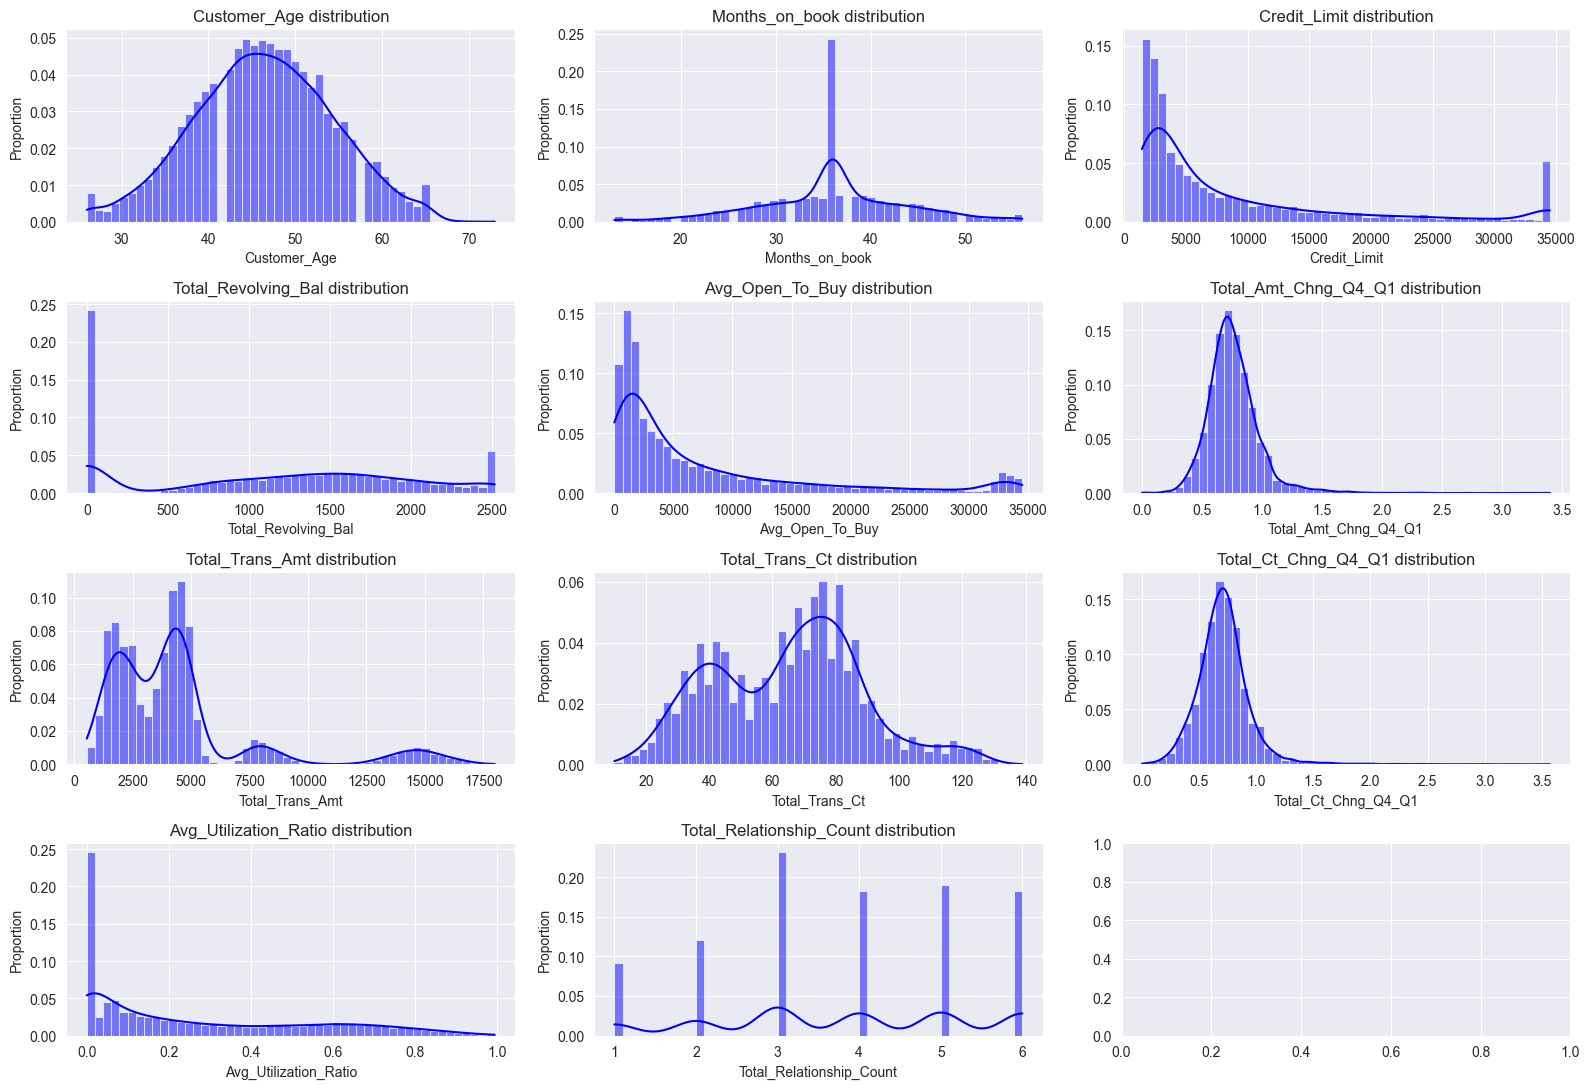

In [ ]:
num_features = ['Customer_Age', 
                'Months_on_book', 
                'Credit_Limit', 
                'Total_Revolving_Bal', 
                'Avg_Open_To_Buy', 
                'Total_Amt_Chng_Q4_Q1', 
                'Total_Trans_Amt', 
                'Total_Trans_Ct', 
                'Total_Ct_Chng_Q4_Q1', 
                'Avg_Utilization_Ratio',
                'Total_Relationship_Count']

fig, axes = plt.subplots(4,3, figsize=(16,11))
for ax, feature in zip(axes.flat, num_features):
    sns.histplot(train[feature], bins=50, stat="proportion",kde=True, color='blue', ax=ax)
    ax.set_ylabel(f'Proportion')
    ax.set_title(f"{feature} distribution")

plt.tight_layout()

* The average customer are ranging between 40-50 years old
* A large part of the customer have been with the bank for exactly 3 years (36 months)
* The credit limit has a right skewed distributions which means much of the customer has a low credit limit. and some portion that accounts of 5% percent of the customer has a high credit card limit
* The average utilazation distribution is right skewed. Almost 25% of the customer is not utilizing their credit card
* A large portion of the customers, also about 25%, have a zero total revolving balance. Lower total revolving balances (specially zero) might indicate a significant likelihood of churn.
* Considering average utilization ratio and total revolving balance present the same proportion of zero records, these variables might be correlated. 

### Outliers

In [30]:
data['Customer_Age']

0        45
1        49
2        51
3        40
4        40
         ..
10122    50
10123    41
10124    44
10125    30
10126    43
Name: Customer_Age, Length: 10127, dtype: int64

In [45]:
def check_outliers(data, features):
    outlier_counts = {}
    total_outliers = 0 
    for feat in features:
        Q1 = data[feat].quantile(0.25)
        Q3 = data[feat].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        feature_outliers = data[(data[feat] < lower_bound) | (data[feat] > upper_bound)]
        outlier_count = len(feature_outliers)
        outlier_counts[feat] = outlier_count
        total_outliers += outlier_count
    print(f'There are {total_outliers} outliers in the dataset.')
    print()
    print(f'Number (percentage) of outliers per feature: ')
    print()
    for feature, count in outlier_counts.items():
        print(f'{feature}: {count} ({round(count/len(data)*100, 2)})%')


In [46]:
check_outliers(data, num_features)

There are 4023 outliers in the dataset.

Number (percentage) of outliers per feature: 

Customer_Age: 2 (0.02)%
Months_on_book: 386 (3.81)%
Credit_Limit: 984 (9.72)%
Total_Revolving_Bal: 0 (0.0)%
Avg_Open_To_Buy: 963 (9.51)%
Total_Amt_Chng_Q4_Q1: 396 (3.91)%
Total_Trans_Amt: 896 (8.85)%
Total_Trans_Ct: 2 (0.02)%
Total_Ct_Chng_Q4_Q1: 394 (3.89)%
Avg_Utilization_Ratio: 0 (0.0)%
Total_Relationship_Count: 0 (0.0)%


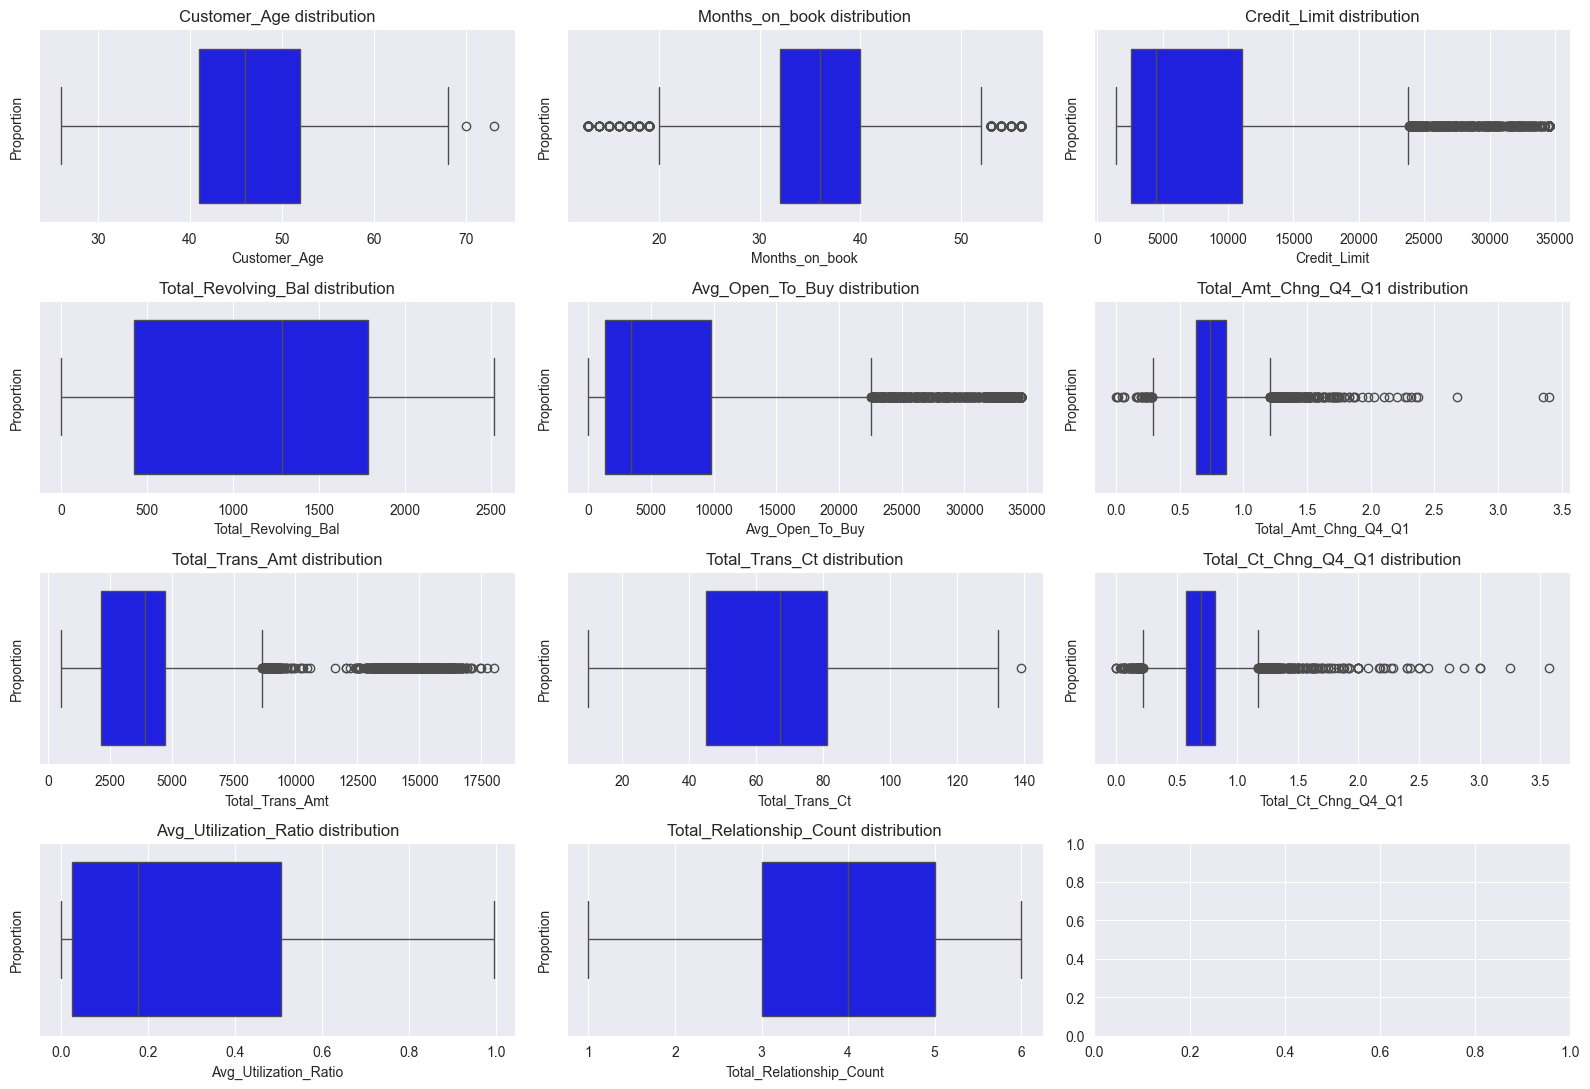

In [50]:
fig, axes = plt.subplots(4,3, figsize=(16,11))
for ax, feature in zip(axes.flat, num_features):
    sns.boxplot(train[feature], color='blue', orient="h",ax=ax)
    ax.set_ylabel(f'Proportion')
    ax.set_title(f"{feature} distribution")

plt.tight_layout()

as we can see on our data plot the proportion of the outliers are small therefore we won't be doing anything for the outliers

### Categorical Feature Distritbution

on this section we will plot the discrete features along with the categorical features

In [ ]:
discrete_features = ['Gender', 
                     'Dependent_count', 
                     'Months_Inactive_12_mon', 
                     'Contacts_Count_12_mon']

cat_features = discrete_features + categorical_featrues

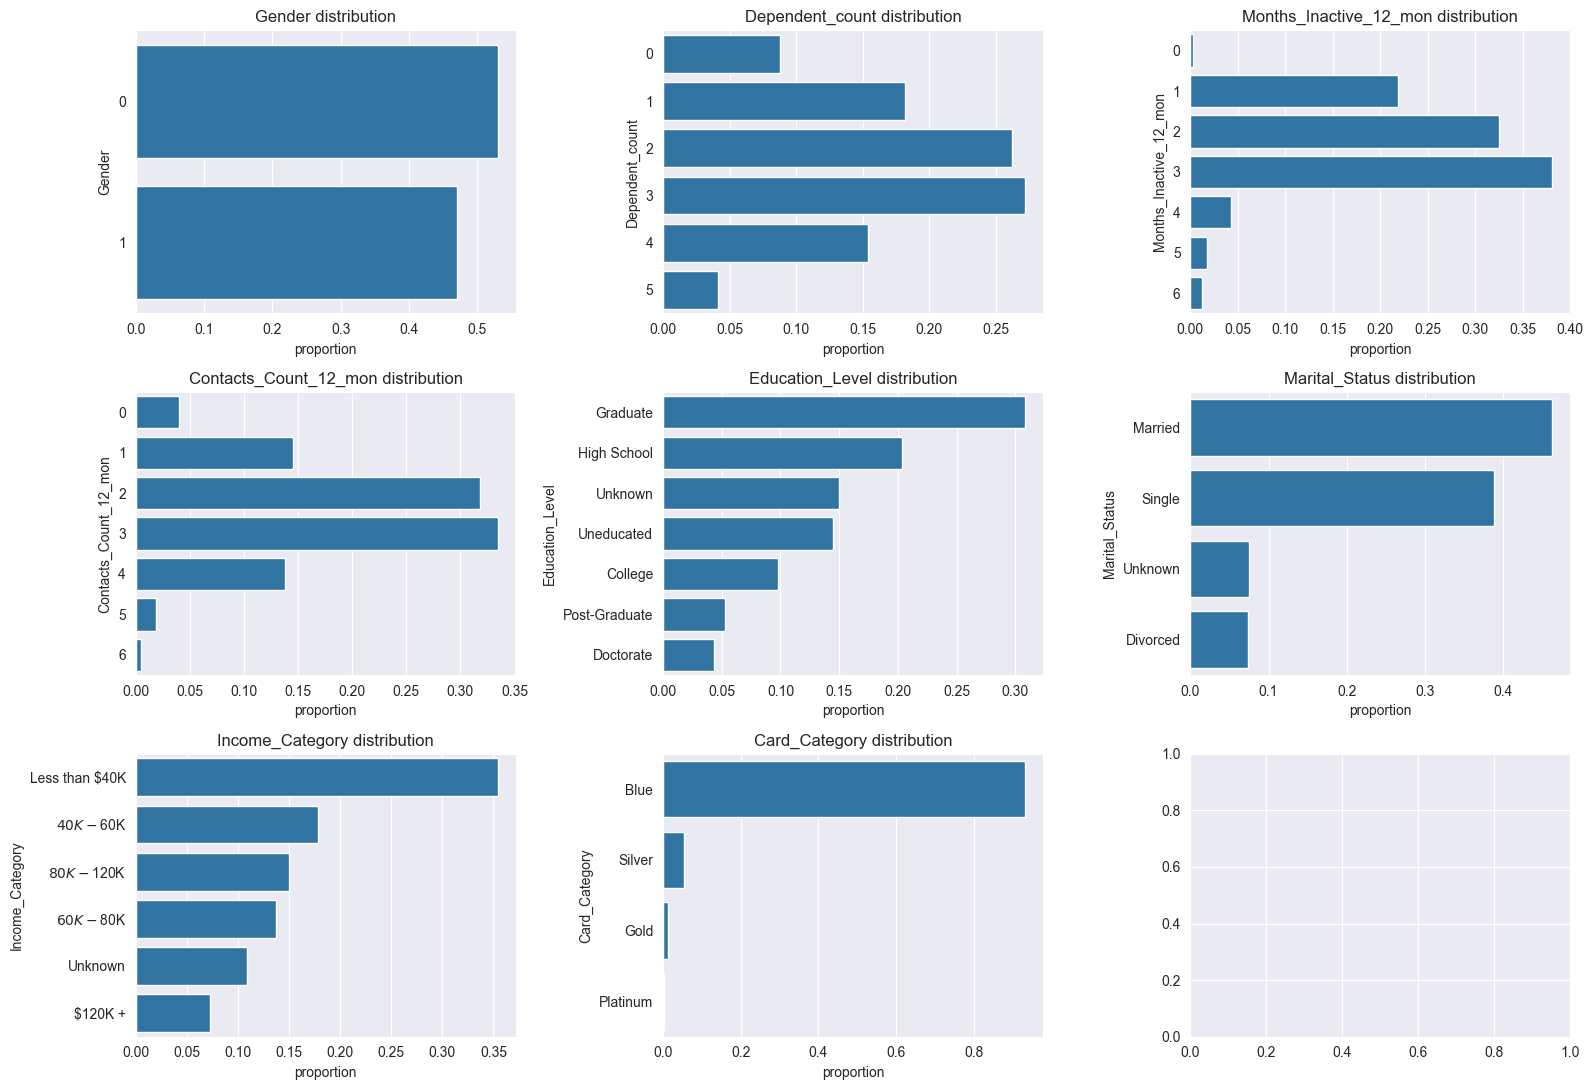

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(16, 11))

for ax, feature in zip(axes.flat, cat_features):
    vc = train[feature].value_counts(normalize=True)
    sns.barplot(x=vc.values,y=vc.index,ax=ax,orient='h')

    ax.set_xlabel("proportion")
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} distribution")


plt.tight_layout()
plt.show()


* More than 50% of the customers are women 
* More than 50% of the customer have 2-3 dependents
* More than 90% of the customer are inactive were inactive in their 1st - 3rd months
* Most of the Customer are graduate, married or single and has an income less then 40K
* There is an imbalanced on the Card_Category_Distribution where blue card holder accounts for 80% from the total proportion. We will take this into accounts on the modeling step. Leaving categories with extremely low proportions of observations can lead to overfitting and card category may not have discriminatory power.

## 2. Bivariate and Multivariate Analysis

In this process we will take a look on the relationship between the variables especially the relationship with the target variable

### Correlation Matrix

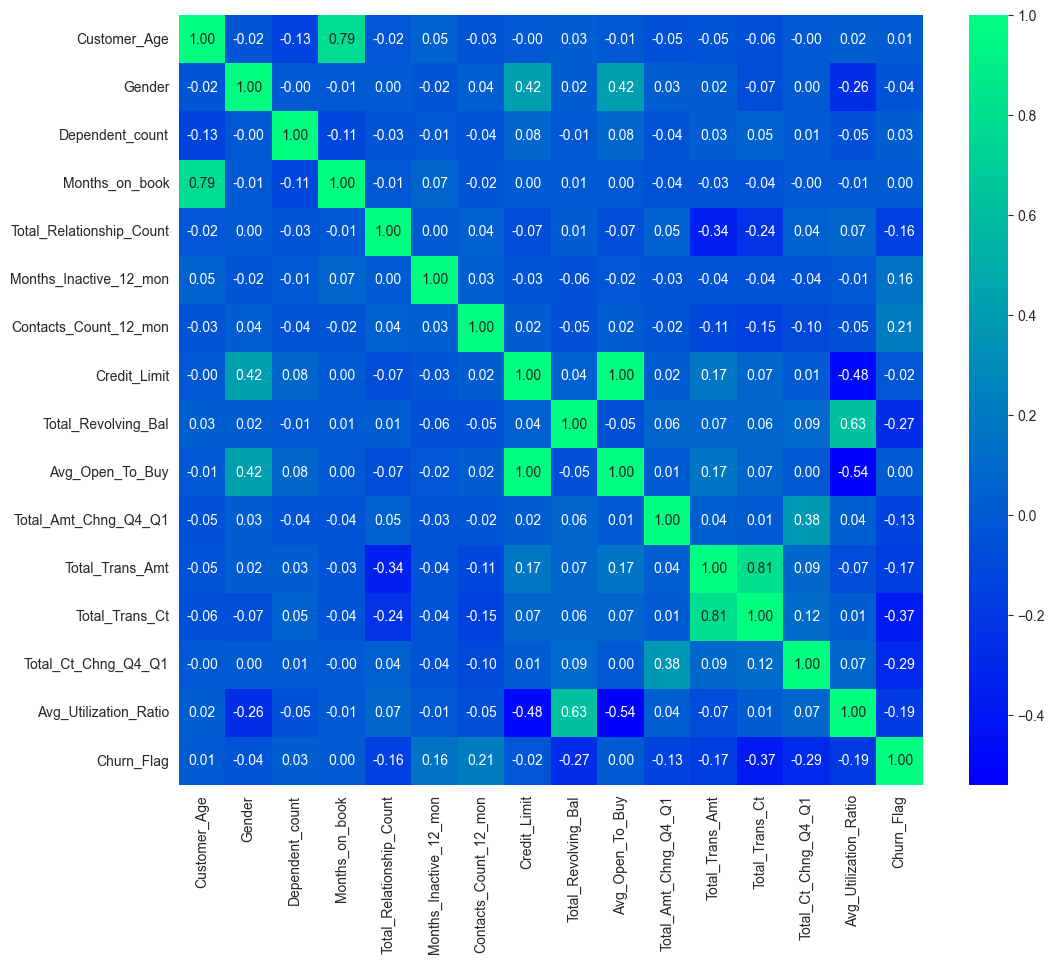

In [95]:
mat_corr = train.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(mat_corr, annot=True, cmap="winter", fmt='.2f')
plt.show()

* the total transaction count, total revolving balance has a negative relationship with the target. This makes total sense since the less the customer do transaction the more likely they are to churn. Also customer with lower revolving balances and less variation in their transaction counts are prone to churn due to their inactivity 

* Customer age and month on book are highly correlated. The older the customer is, the more time he spends consuming the banks credit card and vice versa

* Credit limit and Averate utilization ratio are moderately negative correlated. The higher the customer credit limit, the lower the average utilization ratio

* Total revolving balance and average utilization ration are strongly positive correlated. This make sense, as customer uses more of his credit card, they need to pay more the revolving balance

* Gender has a moderate positive correlation with credit. This might indicate that male customer has a higher credit limit than female customer

* Some features that are naturally related are highly correlated, as expected. This is the case for total transaction amount and total transaction count. When building linear models, we have to worry with multicolinearity issues, which occurs when two or more independent variables are highly correlated. Although it is diagnosed with variance inflation factor, observing pearson correlation between pairs can indicate us this issue. It is the case here. However, once I will focus on predictive power, using more robust algorithms like LightGBM, I will not worry with this now.

* Curiously, average open to buy and credit limit are perfectly positively correlated. This means these two variables have a strong and consistent linear relationship in the same direction. This makes sense since open to buy means the amount left in your credit card to use and limit means the used amount which hasn't been paid off yet. Because they present this perfect correlation, one of them becomes redundant. Thus, I will drop avg_open_to_buy in the modeling step because credit_limit is more informative.

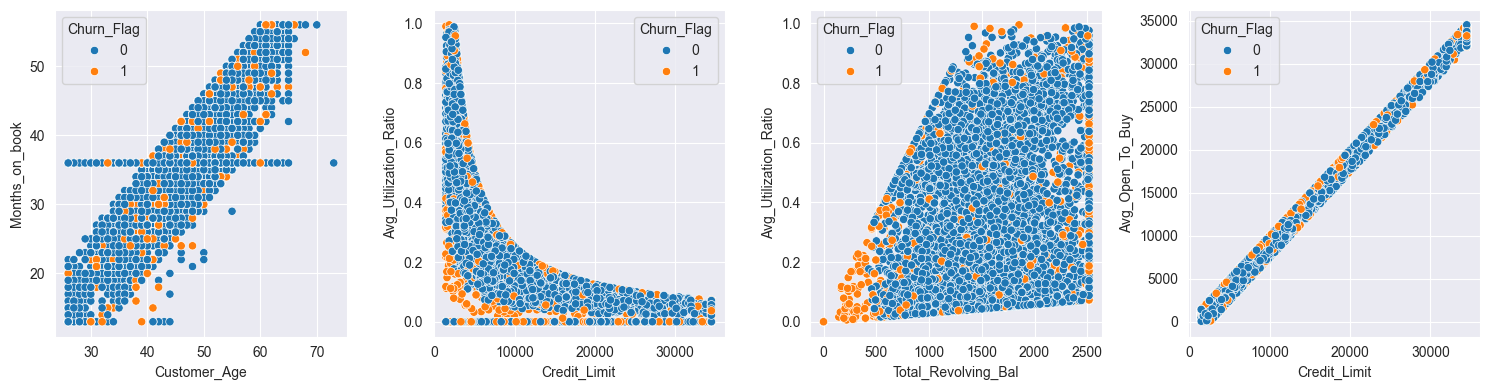

In [96]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
sns.scatterplot(data=train, x='Customer_Age', y='Months_on_book', hue='Churn_Flag', ax=axes[0])
sns.scatterplot(data=train, x='Credit_Limit', y='Avg_Utilization_Ratio',  hue='Churn_Flag', ax=axes[1])
sns.scatterplot(data=train, x='Total_Revolving_Bal', y='Avg_Utilization_Ratio',  hue='Churn_Flag', ax=axes[2])
sns.scatterplot(data=train, x='Credit_Limit', y='Avg_Open_To_Buy',  hue='Churn_Flag', ax=axes[3])
plt.tight_layout()
plt.show()

credit limit and average utilization ratio present an exponential decreasing relationship! This indicates that, as credit limit increases, the average utilization ratio decreases at an exponential rate. Thus, customers with higher credit limits use their credit cards less.

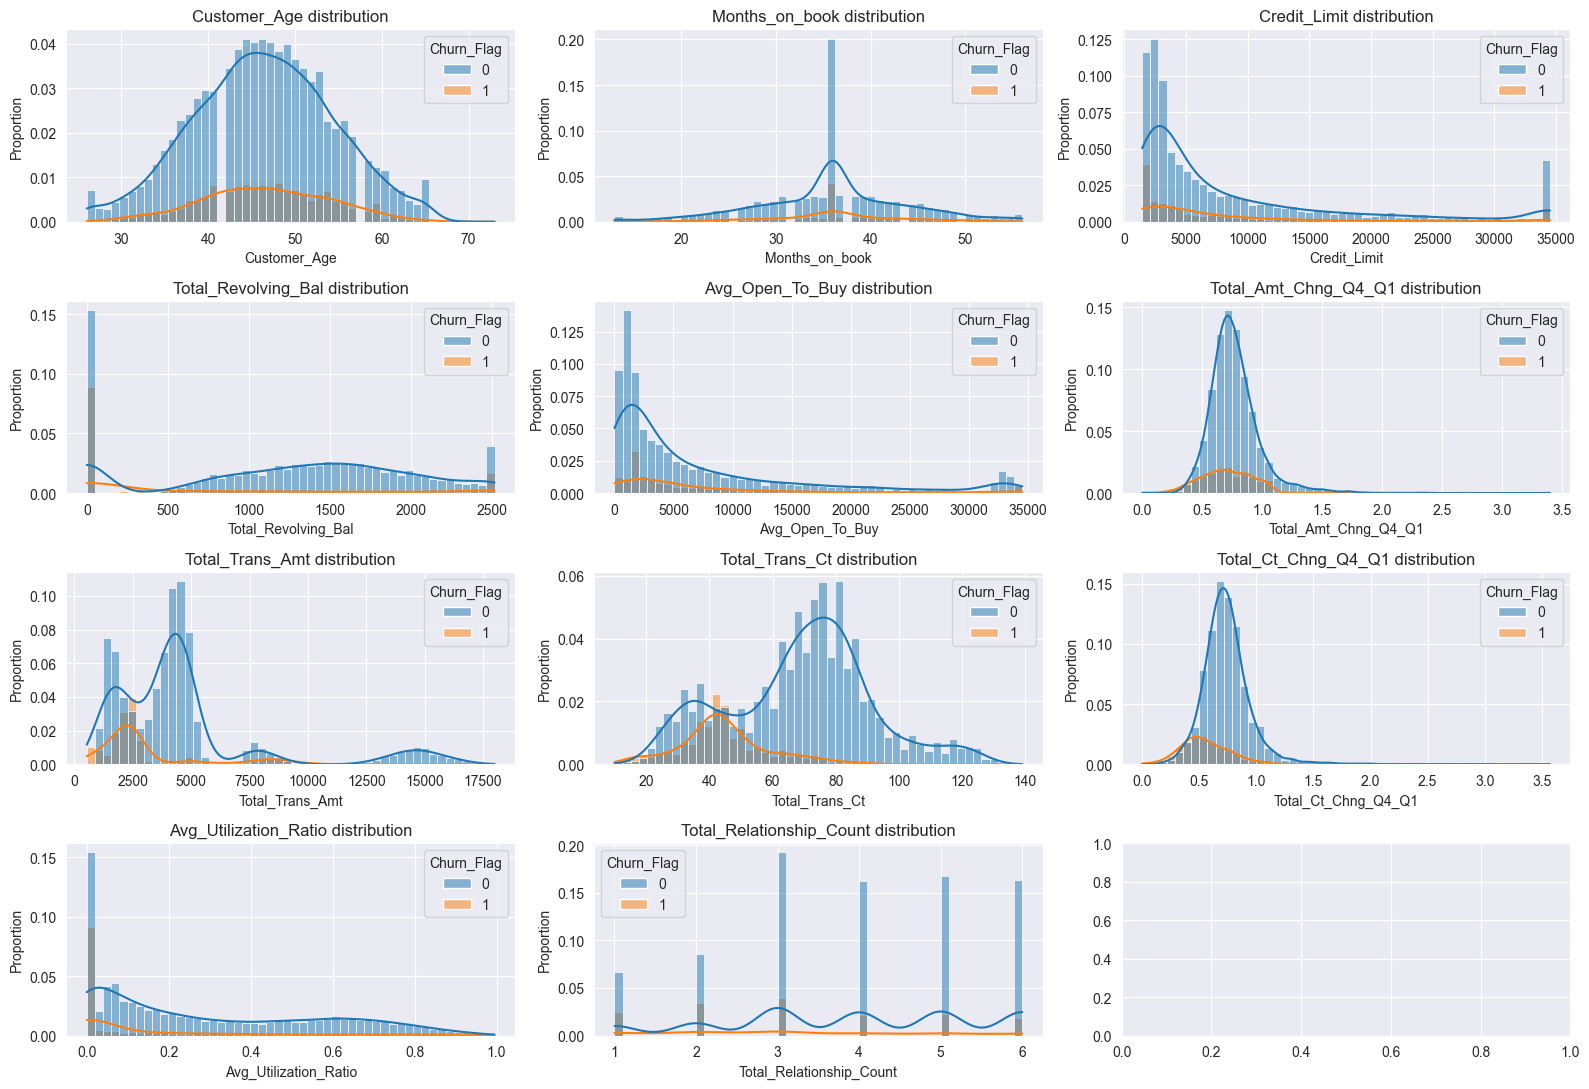

In [100]:
fig, axes = plt.subplots(4,3, figsize=(16,11))
for ax, feature in zip(axes.flat, num_features):
    sns.histplot(train, x=feature, bins=50, hue='Churn_Flag',stat="proportion",kde=True, color='blue', ax=ax)
    ax.set_ylabel(f'Proportion')
    ax.set_title(f"{feature} distribution")

plt.tight_layout()

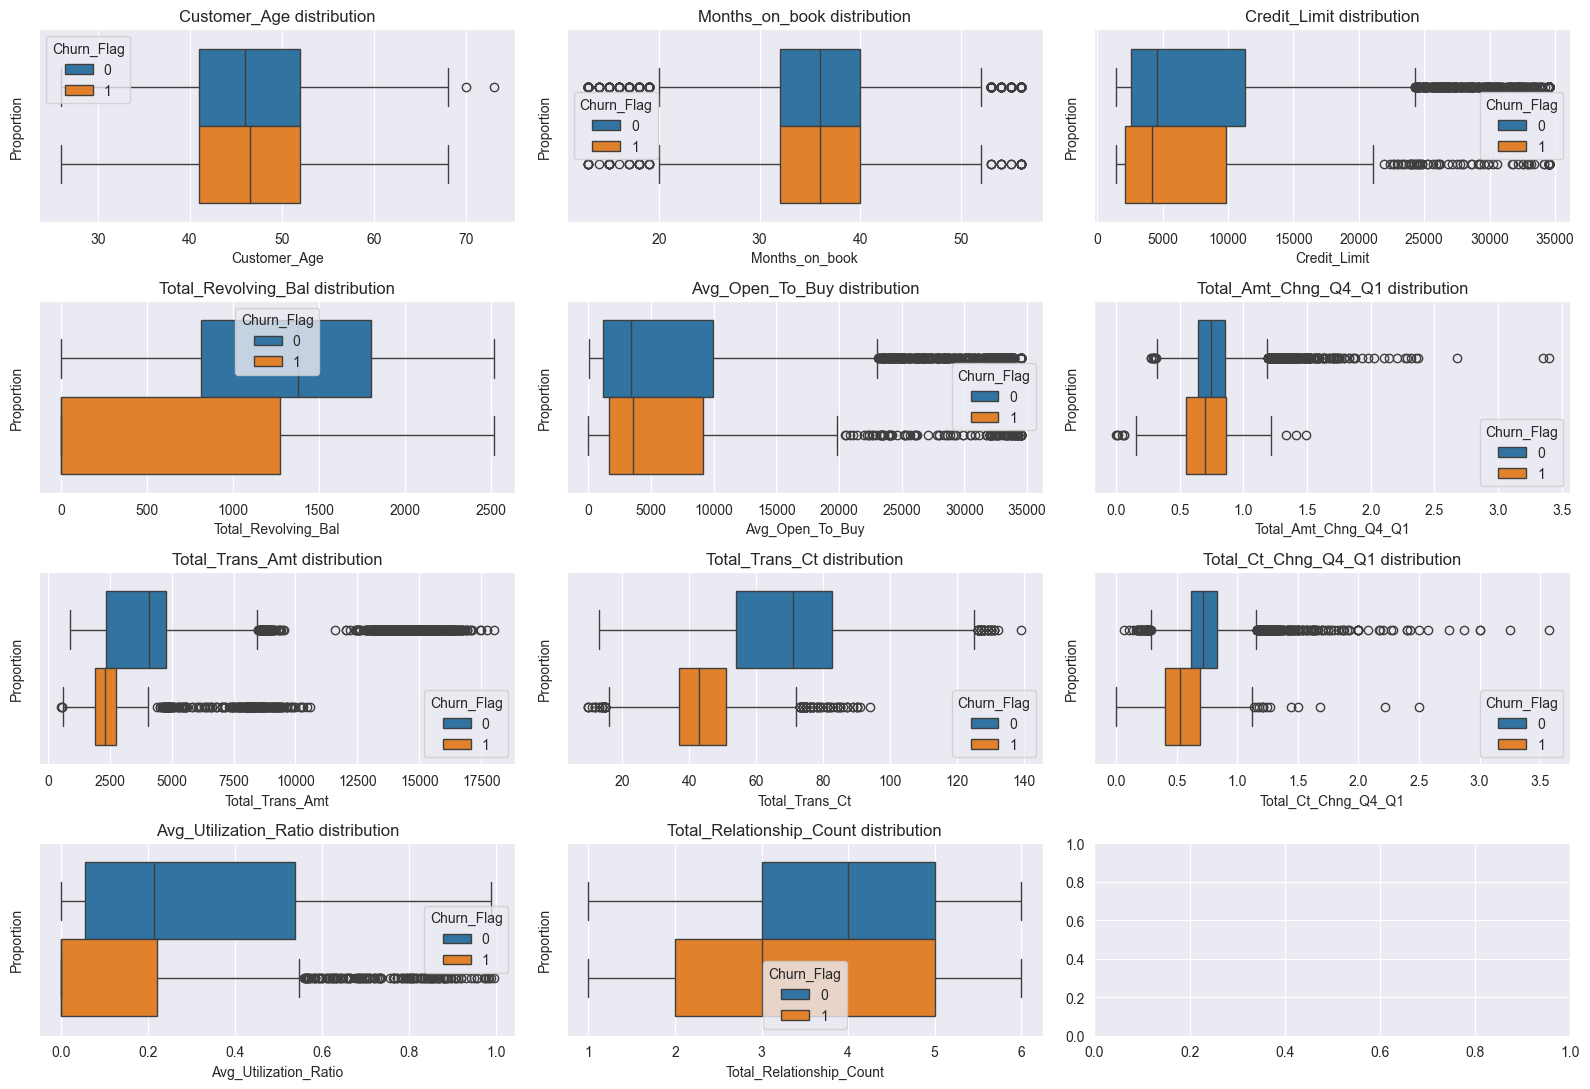

In [102]:
fig, axes = plt.subplots(4,3, figsize=(16,11))
for ax, feature in zip(axes.flat, num_features):
    sns.boxplot(train, x=feature, orient="h",ax=ax, hue="Churn_Flag")
    ax.set_ylabel(f'Proportion')
    ax.set_title(f"{feature} distribution")

plt.tight_layout()

* Customers who churn tend to have fewer products from the bank. Attrited customers generally have between 1 and 3 products

* Customers who churn tend to have slightly lower credit limits.

* Customers who churn tend to have lower revolving balances, which makes sense since churners tend to use their credit cards less. Especially, a large part of them present a zero revolving balance.

* Customers who churn tend to have lower transaction amounts, which makes total sense. When a client is about to discontinue the service, he will make fewer transactions, resulting in lower amounts in a period.

* Customers who churn tend have lower transaction counts, which makes total sense. When a client is about to discontinue the service, he will make fewer transactions.

* Customers who churn tend to have lower changes in their transaction counts, which makes sense since making fewer transactions will reduce the variation in counts.

* As expected, customers who churn tend to have lower average utilization ratio. Particularly, many of them tend to have a zero utilization ratio.

* An important observation is that a good pratice would be to discretize these continuous features to better analyze their distributions per churners and non-churners. However, with the graphs above we can clearly see a discrimination, and, as I intend to focus on predictive power, building more robust models such as LightGBM, in terms of preprocessing, feature discretization would increase dimensionality and probably be harmful.

### Categorical Distribution by Churn Rate

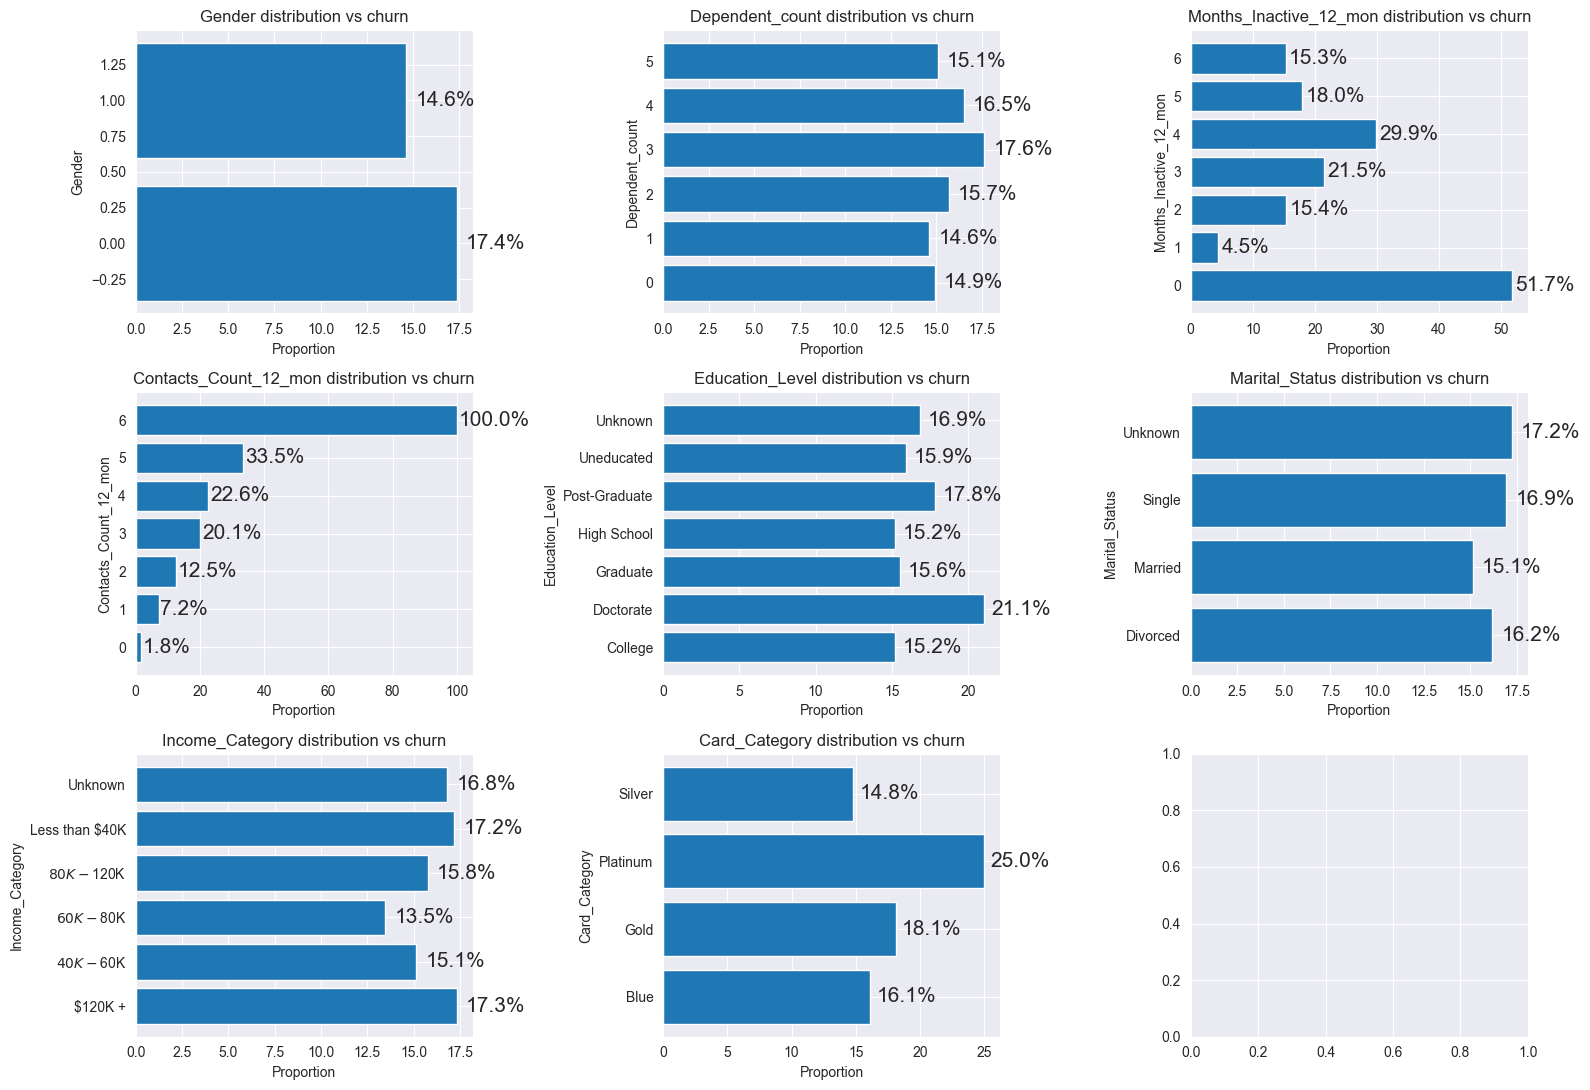

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(16, 11))

for ax, feature in zip(axes.flat, cat_features):
    data_grouped = data.groupby([feature])[['Churn_Flag']].mean().reset_index().rename(columns={'Churn_Flag': 'pct'})
    data_grouped['pct'] *= 100
    ax.barh(y=data_grouped[feature], width=data_grouped['pct'])

    for index, value in enumerate(data_grouped['pct']):
                        # Adjust the text position based on the width of the bars
                        ax.text(value + 0.5, index, f'{value:.1f}%', va='center', fontsize=15)

    ax.set_xlabel("Proportion")
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} distribution vs churn")

plt.tight_layout()
plt.show()


* The churn rate consistently increases monotonically as the number of contacts with the bank rises. Especially, all customers who made six contacts churned.

* In marital_status, the unknown category presents the highest churn rate. For education_level and income_category, it presents the second highest churn rates. Thus, it is a good practice to leave it as another category of these variables in the preprocessing step, once it helps discriminating between churners and non-churners.

* Although card_category is highly imbalanced towards blue type, it is possible to see that the churn rate varies across the categories. Particularly, Platinum presents the highest churn rate. Even having a very low number of observations, as I am focusing on the predictive power, building robust models such as LightGBM, I will leave this variable and assess its feature importance or apply a feature selection method to keep it or remove it further.

* The churn rate is higher for women.

* Surprisingly, customers who were never inactive in the last 12 months present the highest churn rate.

* Customers with doctorate educational level present the highest churn rate among the other levels.

# Feature Engineering, Data Preprocessing, Data Cleaning

In [4]:
data = pd.read_csv('../data/BankChurners.csv')
data.columns = [x.lower() for x in data.columns]

data.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)
data['churn_flag'] = data['churn_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})


X = data.drop(columns=['churn_flag'])
y = data['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Feature Engineering

To extract maximum information from the available features, we will create the following features
- Ratio Feature
    - products_per_dependent (total_relationship_count/dependent_count)
    - trans_amt_per_dependent (total_trans_amt/dependent_count) 
    - trans_ct_per_dependent (total_trans_ct/dependent_count)
    - trans_amt_per_products (total_trans_amt/total_relationship_count)
    - trans_ct_per_products (total_trans_ct/total_relationship_count)
    - avg_trans_amt (total_trans_amt/total_trans_ct)
    - credit_util_rate (total_revolving_bal/credit_limit)
    - proportion_inactive_months (months_inactive_12_mon/months_on_book)
    - products_per_tenure (total_relationship_count/months_on_book)
    - products_per_contacts (total_relationship_count/contacts_count_12_mon)
    - dependents_per_contacts (dependent_count/contacts_count_12_mon)
    - trans_ct_per_contacts (total_trans_ct/contacts_count_12_mon)
    - products_per_inactivity (total_relationship_count/months_inactive_12_mon)
    - dependents_per_inactivity (dependent_count/months_inactive_12_mon)
    - trans_ct_per_inactivity (total_trans_ct/months_inactive_12_mon)
    - trans_amt_per_credit_limit (total_trans_amt/credit_limit)
    - age_per_tenure (customer_age/months_on_book)
    - trans_ct_per_tenure (total_trans_ct/months_on_book)
    - trans_amt_per_tenure (total_trans_amt/months_on_book)

- Sum Feature
    - total_spending (total_trans_amt + total_revolving_bal)
    - education_income_levels (education_level + income_category)
    - inactivity_contacts (contacts_count_12_mon + months_inactive_12_mon)



- We leave the 'unknown' category in income_category, marital_status and education_level as another category of these variables. This is because on eda  this category presents discrimination between churners and non-churners. Specifically, in marital_status, it presents the highest churn rate. For education_level and income_category, it presents the second highest churn rates. Thus, I will not do any imputation. Imputing would introduce bias and information loss.

- I will leave the card_category variable in the data because although it is highly imbalanced, it was observed that Gold and Silver category present some higher churn rates. Once I intend to build robust models such as LightGBM, focusing on predictive power, I will keep this variable and apply a feature selection method to remove it in case it is useless.

- I will drop avg_open_to_buy because I observed it is perfectly positively correlated with credit_limit, turning its information redundant.

- I will drop CLIENTNUM because it has a unique value for each record.



### Preprocessor for linear models

* We will apply standard scaling since linear model are sensitive to scale
* For categorical feature we will apply one hot encoding because with this each feature will has its own weights and the model will not assume there's an ordinal inside our feature

In [5]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = ['gender', 
                             'education_level', 
                             'marital_status', 
                             'income_category', 
                             'card_category']
std_scaling_features = ['customer_age', 
                        'dependent_count', 
                        'months_on_book', 
                        'total_relationship_count', 
                        'months_inactive_12_mon', 
                        'contacts_count_12_mon', 
                        'credit_limit', 
                        'total_revolving_bal', 
                        'avg_open_to_buy', 
                        'total_amt_chng_q4_q1', 
                        'total_trans_amt', 
                        'total_trans_ct', 
                        'total_ct_chng_q4_q1',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'trans_ct_per_dependent',
                        'trans_amt_per_products',
                        'trans_ct_per_products',
                        'avg_trans_amt',
                        'credit_util_rate',
                        'proportion_inactive_months',
                        'products_per_tenure',
                        'products_per_contacts',
                        'dependents_per_contacts',
                        'trans_ct_per_contacts',
                        'products_per_inactivity',
                        'dependents_per_inactivity',
                        'trans_ct_per_inactivity',
                        'trans_amt_per_credit_limit',
                        'age_per_tenure',
                        'trans_ct_per_tenure',
                        'trans_amt_per_tenure',
                        'total_spending',
                        'inactivity_contacts',
                        'education_income_levels']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

linear_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('std_scaler', StandardFeatureScaler(to_scale=std_scaling_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_prepared_linear = linear_preprocessor.fit_transform(X_train)
X_train_prepared_linear.shape

(8101, 55)

In [6]:
X_train_prepared_linear.head()

avg_utilization_ratio  gender_M  education_level_Doctorate  \
0                  0.868         0                          0   
1                  0.000         1                          0   
2                  0.078         1                          0   
3                  0.510         0                          0   
4                  0.034         1                          0   

   education_level_Graduate  education_level_High School  \
0                         0                            0   
1                         0                            1   
2                         0                            1   
3                         1                            0   
4                         1                            0   

   education_level_Post-Graduate  education_level_Uneducated  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   

   education_level_Unknown  marital_status_Married  marital_status_Single  \
0                        1                       1                      0   
1                        0                       0                      1   
2                        0                       1                      0   
3                        0                       1                      0   
4                        0                       0                      1   

   ...  products_per_inactivity  dependents_per_inactivity  \
0  ...                -0.485952                  -1.237821   
1  ...                 0.365249                   0.264667   
2  ...                 0.000449                  -0.570049   
3  ...                 0.730050                   0.765496   
4  ...                 0.000449                  -0.736992   

   trans_ct_per_inactivity  trans_amt_per_credit_limit  age_per_tenure  \
0                -0.880000                   -0.381331        0.816497   
1                -0.663276                   -1.013049       -0.443162   
2                -0.200931                   -0.718602        0.967656   
3                 0.290311                   -0.545573        0.816497   
4                 0.073587                   -0.989645       -0.317196   

   trans_ct_per_tenure  trans_amt_per_tenure  total_spending  \
0            -0.178604             -0.494497       -0.442467   
1            -0.943028             -0.578903       -0.922191   
2             1.160665              0.107518       -0.102463   
3            -0.224470             -0.531703       -0.650920   
4            -0.123566             -0.288816       -0.139928   

   inactivity_contacts  education_income_levels  
0             0.129437                -1.477093  
1             0.129437                 0.026353  
2            -0.526738                 0.527502  
3            -0.526738                 0.026353  
4             0.129437                 2.030949  

[5 rows x 55 columns]

### Construct Preprocessor For Tree Model
* For the tree model we will not apply feature scaling for the numerical feature since tree models are not distance based model
* Categorical Feature that has ordinal characteristic (education_level, income_category, card_category) will be feed into one hot encoding to preserve its characteristic
* Marital Status will be applied target encoding since, one hot encoding can be harmful to tree based models
* One hot enoding will be applied only to gender because it will be converted into unique binary variable, and not increasing the dimensionality

In [7]:
one_hot_encoding_features = ['gender']

ordinal_encoding_orders = {
    'education_level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'income_category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'card_category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}

target_encoding_features = ['marital_status']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

tree_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
        ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_prepared_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_train_prepared_tree.shape

(8101, 40)

In [8]:
X_train_prepared_tree.head()

customer_age  dependent_count  months_on_book  total_relationship_count  \
0            36                0              24                         4   
1            44                3              36                         5   
2            46                2              30                         6   
3            36                2              24                         3   
4            50                1              40                         4   

   months_inactive_12_mon  contacts_count_12_mon  credit_limit  \
0                       3                      2        2570.0   
1                       2                      3       25276.0   
2                       3                      1       11670.0   
3                       1                      3        3124.0   
4                       2                      3       34516.0   

   total_revolving_bal  total_amt_chng_q4_q1  total_trans_amt  ...  \
0               2230.0                 0.686           1755.0  ...   
1                  0.0                 0.849           2282.0  ...   
2                915.0                 0.892           4277.0  ...   
3               1593.0                 0.869           1652.0  ...   
4               1185.0                 0.725           3874.0  ...   

   trans_ct_per_tenure  trans_amt_per_tenure  total_spending  \
0             1.750000             73.125000            3985   
1             1.055556             63.388889            2282   
2             2.966667            142.566666            5192   
3             1.708333             68.833336            3245   
4             1.800000             96.849998            5059   

   inactivity_contacts  education_income_levels  gender_M  education_level  \
0                    5                        0         0                6   
1                    5                        3         1                1   
2                    4                        4         1                1   
3                    4                        3         0                3   
4                    5                        7         1                3   

   income_category  card_category  marital_status  
0                0              0        0.153397  
1                2              1        0.168998  
2                3              0        0.153397  
3                0              0        0.153397  
4                4              0        0.168998  

[5 rows x 40 columns]

# Model Training, Comparison, Selection & Tuning

- In this step, I intend to compare different models performances. In order to achieve this, I will use stratified k-fold cross validation to train each one of them and evaluate their ROC-AUC score. Accuracy is not a good metric because the target is imbalanced. Moreover, stratified k-fold cross validation will maintain the target proportion on each fold, dealing with the imbalanced target as well.

- K-fold cross-validation is a technique used in machine learning to assess the performance of a model. It involves dividing the dataset into K subsets, using K-1 for training and one for testing iteratively. This helps in estimating a model's generalization ability by reducing the risk of overfitting and providing more reliable performance metrics.


In [9]:
# Define linear and tree-based models dictionaries for k-fold cross validation.
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

Logistic Regression results: 
--------------------------------------------------
Training score: 0.8148340125919845
Average validation score: 0.9428015959558291
Standard deviation: 0.005196293958667355
Training time: 0.18977 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.813085540048471
Average validation score: 0.942389109925835
Standard deviation: 0.005037953328984032
Training time: 0.04554 seconds

KNN results: 
--------------------------------------------------
Training score: 0.8708612159238202
Average validation score: 0.9289137881952014
Standard deviation: 0.01102718807675875
Training time: 0.00255 seconds



model  avg_val_score  train_score
0  Logistic Regression       0.942802     0.814834
1           Linear SVC       0.942389     0.813086
2                  KNN       0.928914     0.870861

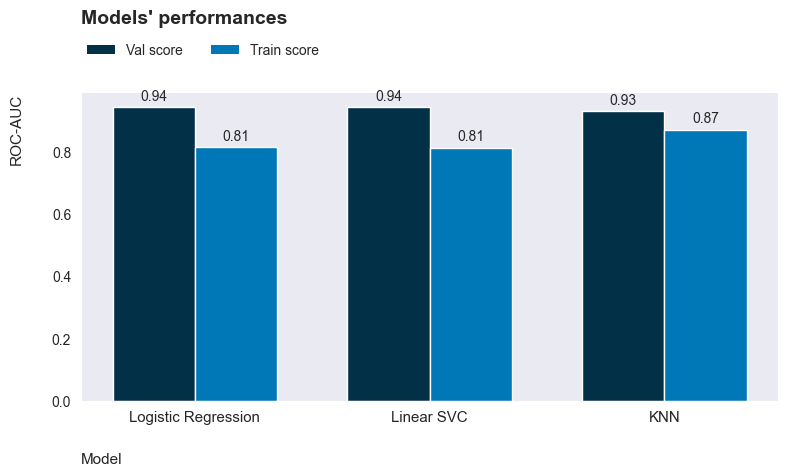

In [10]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train_prepared_linear, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.8710151995199448
Standard deviation: 0.007993906084281495
Training time: 0.17242 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9877944921695698
Standard deviation: 0.0033957711711673144
Training time: 1.79352 seconds

[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5536
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
[LightGBM] [Info] 

model  avg_val_score  train_score
0       LightGBM       0.992292          1.0
1  Random Forest       0.987794          1.0
2  Decision Tree       0.871015          1.0

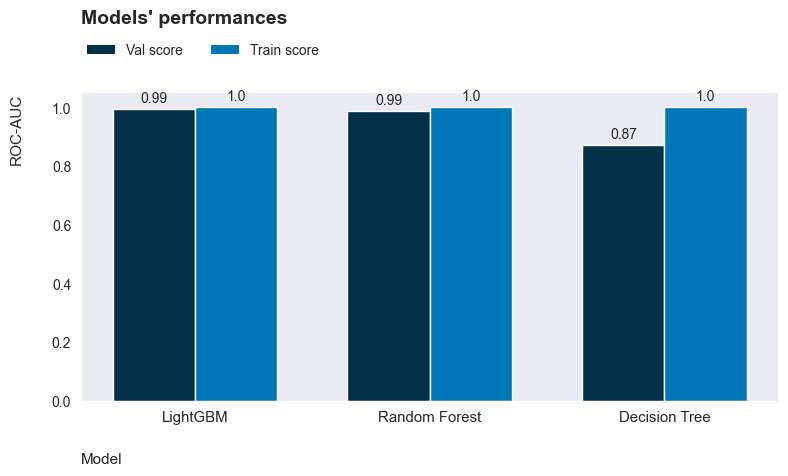

In [11]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train_prepared_tree, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

## Feature Selection 

* feature selection is important in improving the model generalization ability and making it less complex, thus reducing computational cost
* Given that we have 40 features, simplifying the model without losing its performance is highly advantageous
* We will use Recursive Feature Elimination (RFE) for the feature selection
* Recursive Feature Elimination (RFE) is a feature selection method that systematically removes irrelevant or less important features from a predictive model. It works by recursively training the model on subsets of features, ranking them based on their importance, and eliminating the least important features until the desired number of features is reached
* An important hyperparameter of RFE is the final desired number of features. In order to automatically select this value, I will use sklearn's RFECV class. It will apply stratified k-fold cross validation to find the best value for this hyperparameter.

In [12]:
rfe = RecursiveFeatureEliminator(n_folds=5, 
                                 scoring='roc_auc',
                                 estimator=LGBMClassifier())
rfe.fit(X_train_prepared_tree, y_train)
X_train_selected = rfe.transform(X_train_prepared_tree)
X_train_selected.shape

[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5524
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGB

(8101, 25)

In [13]:
X_train_selected.head()

customer_age  contacts_count_12_mon  credit_limit  total_revolving_bal  \
0          36.0                    2.0        2570.0               2230.0   
1          44.0                    3.0       25276.0                  0.0   
2          46.0                    1.0       11670.0                915.0   
3          36.0                    3.0        3124.0               1593.0   
4          50.0                    3.0       34516.0               1185.0   

   total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
0                 0.686           1755.0            42.0                0.448   
1                 0.849           2282.0            38.0                0.583   
2                 0.892           4277.0            89.0                0.854   
3                 0.869           1652.0            41.0                0.367   
4                 0.725           3874.0            72.0                0.714   

   avg_utilization_ratio  trans_amt_per_dependent  ...  products_per_tenure  \
0                  0.868                 0.000000  ...             0.166667   
1                  0.000               760.666687  ...             0.138889   
2                  0.078              2138.500000  ...             0.200000   
3                  0.510               826.000000  ...             0.125000   
4                  0.034              3874.000000  ...             0.100000   

   trans_ct_per_contacts  products_per_inactivity  trans_ct_per_inactivity  \
0              21.000000                 1.333333                14.000000   
1              12.666667                 2.500000                19.000000   
2              89.000000                 2.000000                29.666666   
3              13.666667                 3.000000                41.000000   
4              24.000000                 2.000000                36.000000   

   trans_amt_per_credit_limit  age_per_tenure  trans_ct_per_tenure  \
0                    0.682879        1.500000             1.750000   
1                    0.090283        1.222222             1.055556   
2                    0.366495        1.533333             2.966667   
3                    0.528809        1.500000             1.708333   
4                    0.112238        1.250000             1.800000   

   trans_amt_per_tenure  total_spending  education_income_levels  
0             73.125000          3985.0                      0.0  
1             63.388889          2282.0                      3.0  
2            142.566666          5192.0                      4.0  
3             68.833336          3245.0                      3.0  
4             96.849998          5059.0                      7.0  

[5 rows x 25 columns]

In [14]:
X_train_selected.columns.tolist()

['customer_age',
 'contacts_count_12_mon',
 'credit_limit',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_trans_ct',
 'total_ct_chng_q4_q1',
 'avg_utilization_ratio',
 'trans_amt_per_dependent',
 'trans_ct_per_dependent',
 'trans_amt_per_products',
 'trans_ct_per_products',
 'avg_trans_amt',
 'proportion_inactive_months',
 'products_per_tenure',
 'trans_ct_per_contacts',
 'products_per_inactivity',
 'trans_ct_per_inactivity',
 'trans_amt_per_credit_limit',
 'age_per_tenure',
 'trans_ct_per_tenure',
 'trans_amt_per_tenure',
 'total_spending',
 'education_income_levels']

* As we can see, features that showed a clear discrimination between churners and non-churners were maintained, such as total_trans_ct and total_trans_amt. Moreover, a lot of features created from the feature engineering were also maintained, demonstrating the importance of this task for model's performance.
* As a result, we went from 40 features to 25 final most important features, significantly reducing the computational complexity.

In [15]:
import optuna
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMClassifier(**params)
    
    # Obtain average stratified k-fold cross validation roc-auc score.
    stratified_kfold = StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=42)
    val_scores = cross_val_score(model, 
                                 X_train_selected, 
                                 y_train, 
                                 scoring='roc_auc', 
                                 cv=stratified_kfold)
    avg_roc_auc = val_scores.mean()
    
    return avg_roc_auc

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-12-03 13:07:50,906] A new study created in memory with name: no-name-7a22e858-200b-484f-8515-a1148b32a9ee


[I 2025-12-03 13:08:30,757] Trial 0 finished with value: 0.9910953233366729 and parameters: {'learning_rate': 0.006540274985014438, 'num_leaves': 141, 'subsample': 0.42054567332068243, 'colsample_bytree': 0.23265229614779184, 'min_data_in_leaf': 26}. Best is trial 0 with value: 0.9910953233366729.
[I 2025-12-03 13:11:05,671] Trial 1 finished with value: 0.9817891827142736 and parameters: {'learning_rate': 0.005053109812890706, 'num_leaves': 401, 'subsample': 0.8911441028255271, 'colsample_bytree': 0.08333342237616516, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.9910953233366729.
[I 2025-12-03 13:11:27,520] Trial 2 finished with value: 0.9920436182082317 and parameters: {'learning_rate': 0.05359203549263874, 'num_leaves': 63, 'subsample': 0.38375381632852557, 'colsample_bytree': 0.7867157807095763, 'min_data_in_leaf': 51}. Best is trial 2 with value: 0.9920436182082317.
[I 2025-12-03 13:11:54,285] Trial 3 finished with value: 0.9855530603052649 and parameters: {'learning_rate

Best Hyperparameters: {'learning_rate': 0.05755252502644004, 'num_leaves': 793, 'subsample': 0.9840860053266375, 'colsample_bytree': 0.9330760948264634, 'min_data_in_leaf': 71}


In [16]:
best_params = {'objective': 'binary',
               'metric': 'roc_auc',
               'n_estimators': 1000,
               'verbosity': -1,
               'bagging_freq': 1,
               'class_weight': 'balanced', 
               'learning_rate': 0.017535345166904838,
               'num_leaves': 942,
               'subsample': 0.8490611533540497,
               'colsample_bytree': 0.3775159533799494,
               'min_data_in_leaf': 90}

lgb_clf = LGBMClassifier(**best_params)
lgb_clf.fit(X_train_selected, y_train)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.3775159533799494,
               learning_rate=0.017535345166904838, metric='roc_auc',
               min_data_in_leaf=90, n_estimators=1000, num_leaves=942,
               objective='binary', subsample=0.8490611533540497, verbosity=-1)

In [17]:
X_test_prepared = tree_preprocessor.transform(X_test)
X_test_selected = rfe.transform(X_test_prepared)
X_test_selected.shape

(2026, 25)

In [18]:
y_pred = lgb_clf.predict(X_test_selected)

In [19]:
churn_probas = lgb_clf.predict_proba(X_test_selected)[:, 1]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.90      0.89      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Brier Score: 0.03
Gini: 0.98
KS: 0.9


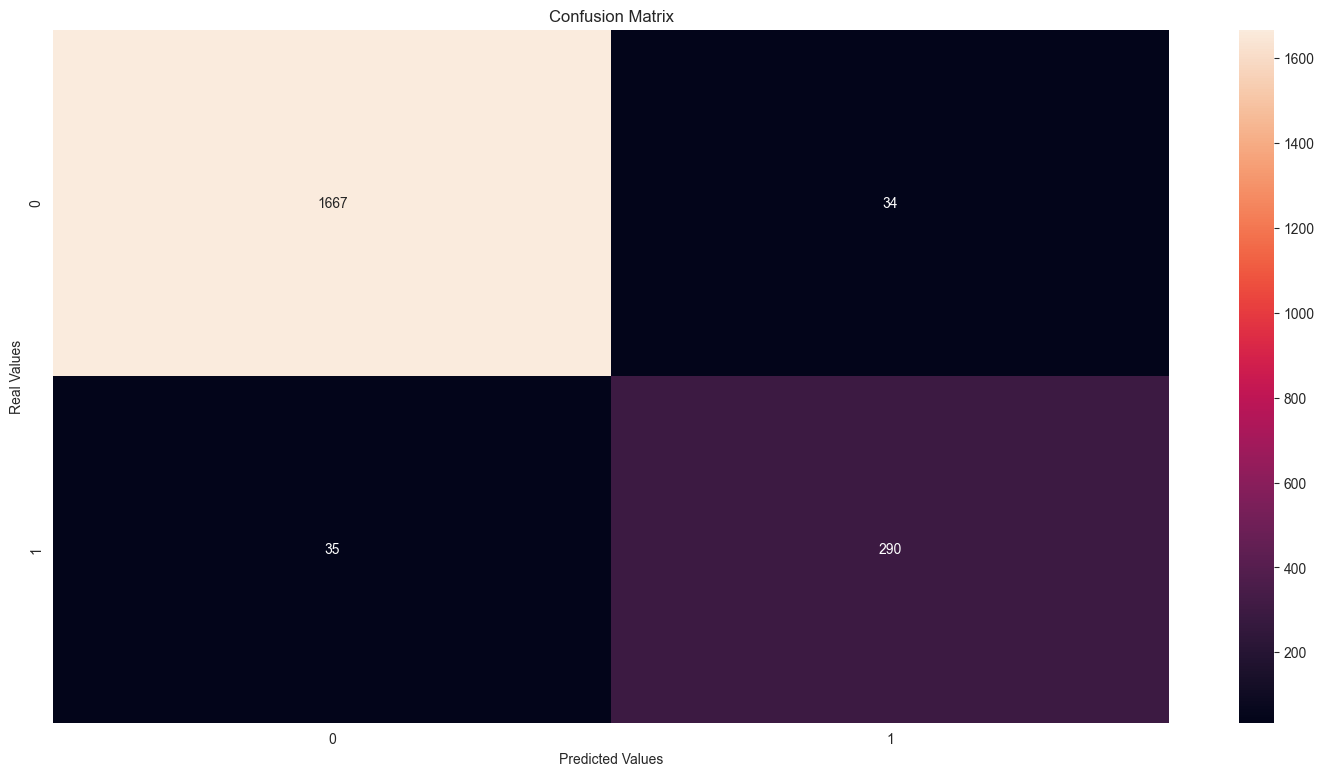

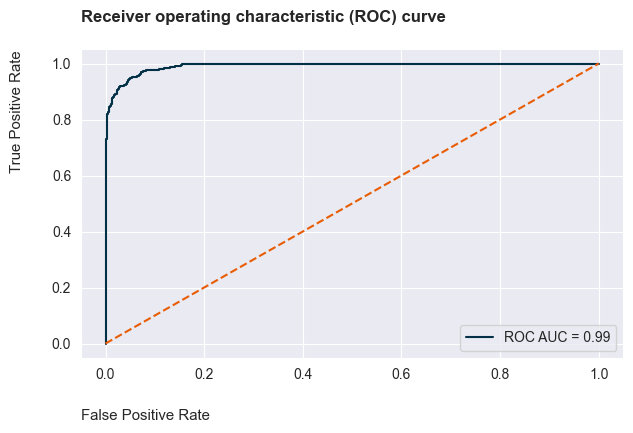

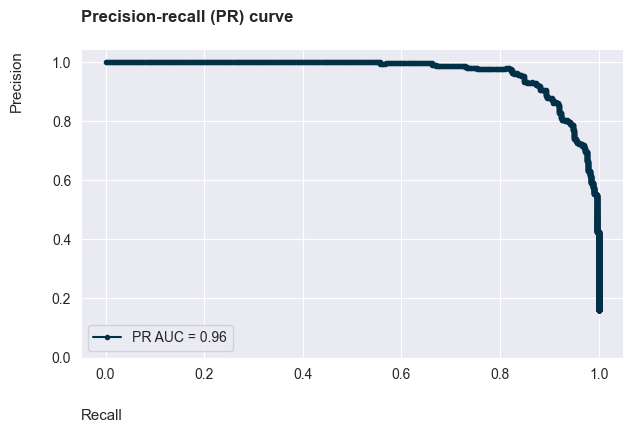

In [20]:
model_metrics = evaluate_classifier(y_test, y_pred, churn_probas)